# Predicting Wind Turbine Yield - ARIMA

Author: Daniel Grzebyk

Date: 17.09.2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import ceil, floor, sqrt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

from utils import remove_outliers_iqr

## Loading the data

In [2]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [3]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [4]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [5]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Time Series EDA
The below figures investigate active power generation over different periods of time. The most active power is generated in the afternoon, between 4pm and 9pm, the least is generated between 1am and 8am. This could be correlated with wind speeds in the area, but wind speed information is not available in this dataset to check it.

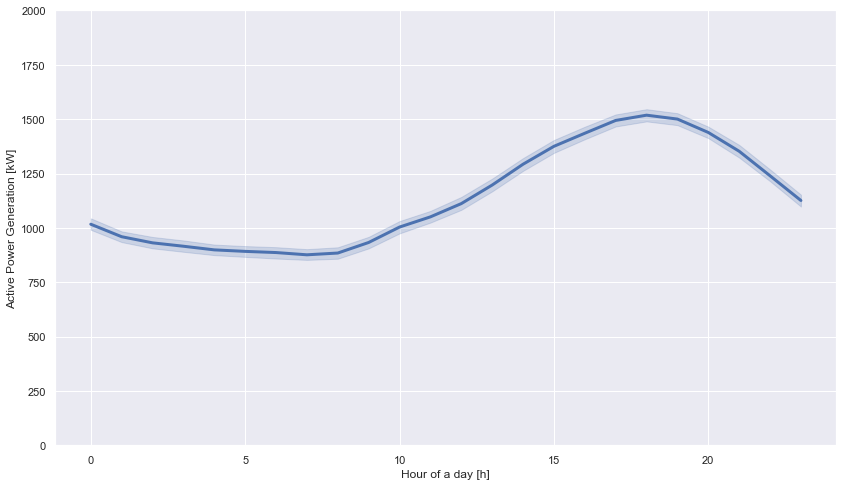

In [6]:
# Seasonal plot showing daily seasonal patterns
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=power, x=power.index.hour, y='Power(kW)', lw=3)

plt.xlabel('Hour of a day [h]')
plt.ylabel('Active Power Generation [kW]')
plt.ylim([0, 2000])
plt.show()

As expected, active power generation is independent of the day of the week. This might be correlated with wind speeds in the area which probably depend on season, rather than workday / holidays. This hypothesis cannot be verified due to lack of data.

C:\Users\danie\AppData\Local\Temp\ipykernel_15604\1814543071.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, rotation='vertical') # , fontsize=18


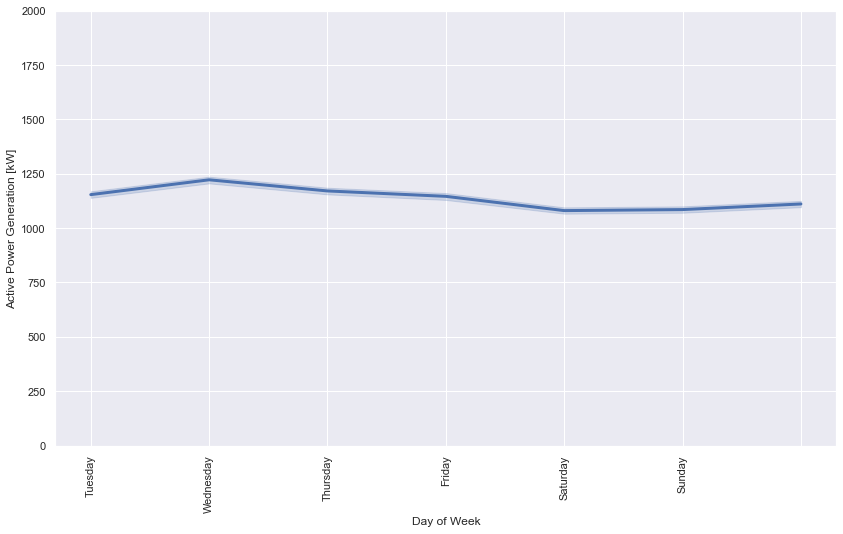

In [7]:
# Seasonal plot showing weekly patterns
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=power, x=power.index.dayofweek, y='Power(kW)', lw=3)

x_ticks_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_xticklabels(x_ticks_labels, rotation='vertical') # , fontsize=18
plt.xlabel('Day of Week')
plt.ylabel('Active Power Generation [kW]')
plt.ylim([0, 2000])
plt.show()

Figure below compares active power generation across 2019-2020-2021 and shows that power production follows a yearly pattern. Therefore, the data is seasonal.

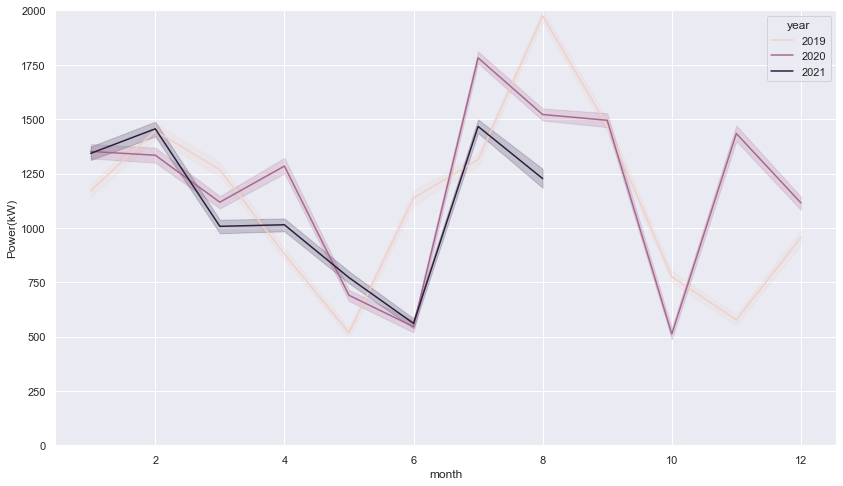

In [8]:
# Seasonal plot showing seasonal patterns
power['month'] = power.index.month
power['year'] = power.index.year

sns.lineplot(data=power, x='month', y='Power(kW)', hue='year', legend='full')
plt.ylim([0, 2000])
plt.show()

del power['month']
del power['year']

## ARIMA
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

1. __Model Identification__. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
2. __Parameter Estimation__. Use a fitting procedure to find the coefficients of the regression model.
3. __Model Checking__. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

"Three factors define ARIMA model, it is defined as ARIMA(p,d,q) where p, d, and q denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively." [1]

_Requirements of ARIMA_:
- time series must be stationary which means it cannot depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. To remove this correlation, ARIMA uses differencing to make the data stationary. Differencing, at its simplest, involves taking the difference of two adjacent data points.

_Partial Correlation vs. Autcorrelation_

Autocorrelation between X and Z will take into account all changes in X whether coming from Z directly or through Y. Partial autocorrelation removes the indirect impact of Z on X coming through Y. [2]

ARIMA assigns smaller weights to values further in the past. 

In [11]:
input_data = power['Power(kW)']# .resample("H").mean()
input_data_diff = input_data.diff()

__Selecting "d" - the order of differencing__

Augmented Dickey-Fuller test is used to check if the time series of wind turbine power is stationary. Its null hypothesis states that there is a unit root while the alternative hypothesis states that the time series is stationary. p-value is lower than significance level of 0.05 which allows us to reject the null hypothesis in favour of the alternative. According to the test, this time series is stationary.

In [12]:
result = adfuller(input_data.dropna().values)
print(f"pvalue: {result[1]}, \n\nTest statistic: {result[0]}, \nused lag: {result[2]},"
      f"\nnumber of observations: {result[3]}, \ncritical values: {result[4]}, \nicbest: {result[5]}")

pvalue: 0.0, 

Test statistic: -20.243008009091703, 
used lag: 73,
number of observations: 136656, 
critical values: {'1%': -3.430397853170283, '5%': -2.8615611504140697, '10%': -2.566781257614413}, 
icbest: 1823712.8611867912


In [13]:
# result = adfuller(input_data_diff.dropna().values)
# print(f"pvalue: {result[1]}, \n\nTest statistic: {result[0]}, \nused lag: {result[2]},"
#       f"\nnumber of observations: {result[3]}, \ncritical values: {result[4]}, \nicbest: {result[5]}")

Looking at the autocorrelation of raw data it can be seen that the time series is non-stationary. 
__This contradicts the ADF test?__

After applying first order differencing, autocorrelation quickly reduces and becomes negative for the second element. Therefore, the first order differencing is sufficient to make the time series non-stationary, and d = 1 is selected.

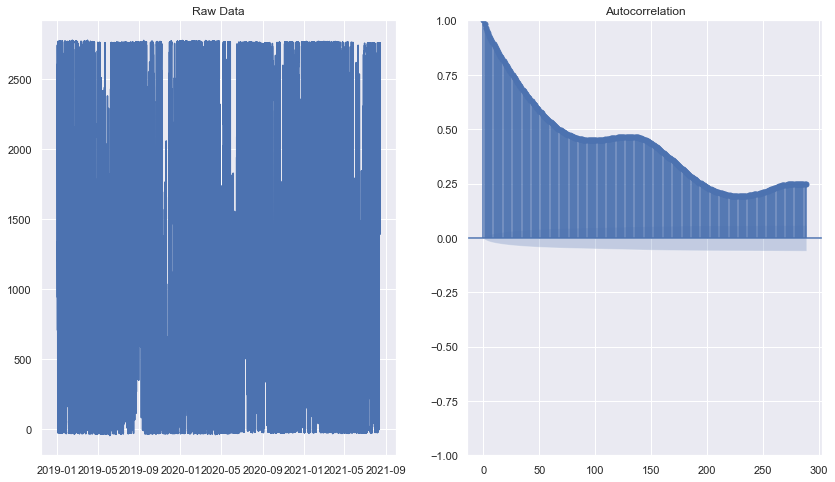

In [14]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("Raw Data")
ax1.plot(input_data)

ax2 = f.add_subplot(122)
plot_acf(input_data, lags=288, ax=ax2)
plt.show()

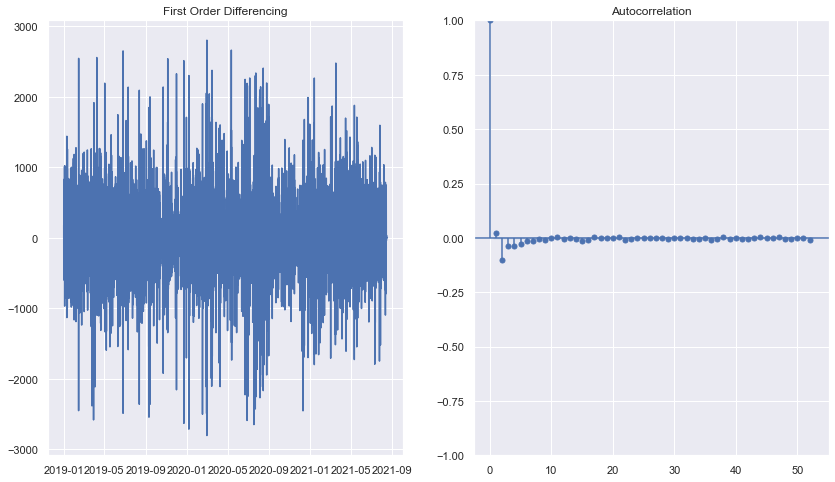

In [15]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("First Order Differencing")
ax1.plot(input_data_diff)

ax2 = f.add_subplot(122)
plot_acf(input_data_diff.dropna(), ax=ax2)  # , lags=288
plt.show()

__Selecting "q" value - the size of the moving average window__

For the first-order differencing, lag 2 has the largest autocorrelation with lag 0, hence q = 2 is selected.

__Selecting "p" value - the number of lagged (or past) observations to consider for autoregression__

After differencing, lag 2 has the strongest partial autocorrelation with lag = 0, hence p = 2 is selected.

C:\Users\danie\anaconda3\envs\internalProject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


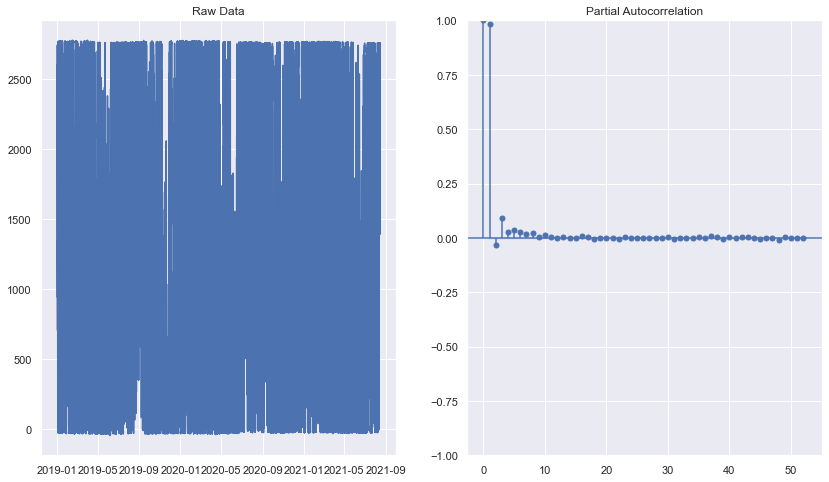

In [16]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("Raw Data")
ax1.plot(input_data)

ax2 = f.add_subplot(122)
plot_pacf(input_data.dropna(), ax=ax2)  # , lags=288
plt.show()

C:\Users\danie\anaconda3\envs\internalProject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


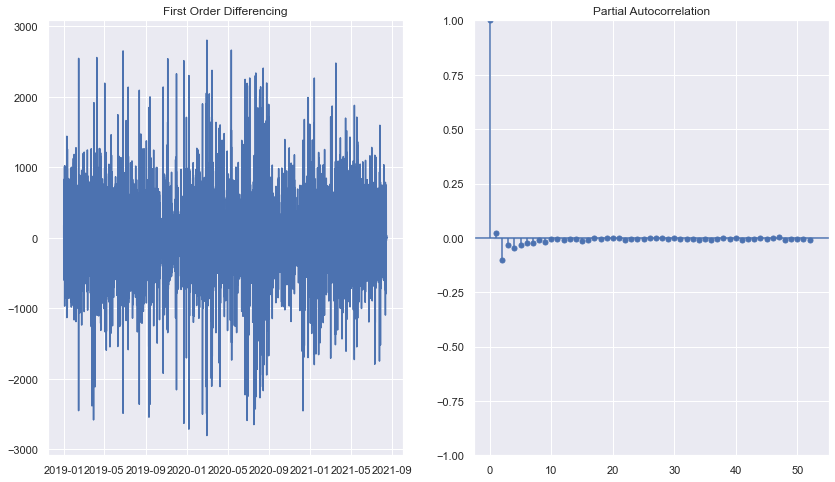

In [29]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("First Order Differencing")
ax1.plot(input_data_diff)

ax2 = f.add_subplot(122)
plot_pacf(input_data_diff.dropna(), ax=ax2)  # , lags=288
plt.show()

__Splitting the data__

_Option 1_: 2 years for training and the incomplete year 2021 for testing. --> Will the quality of predictions worsen over time?

_Option 2_: sliding window of 1 year for training and then sliding test set of 1 day ahead

__Training the model__

TODOs:
- understand the summary statistics of ARIMA - how to compare which model is best?
- why the predictions decrease exponentially and after 20 samples become constant?
- make day-ahead predictions - includes 144 observations in the future

My questions:
- Why does the ADF test claim that time series is stationary while the autcorrelation plot clearly shows it is not stationary?
- Why I cannot train the model to use all samples corresponding to past day for predictions? Why there cannot be p = 144? I know that it is agains the methodology and that after differencing the autocorrelation is gone, but it still doesn't make sense to me.
- Should the sliding window for predictions be equal to the number of samples considered by the model?

In [18]:
TEST_SIZE = 144
train, test = input_data.iloc[:-TEST_SIZE], input_data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], input_data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((136586,), (136586,), (144,), (144,))

In [22]:
from pmdarima.arima import auto_arima

TEST_SIZE = 144
train, test = input_data.iloc[:-TEST_SIZE], input_data.iloc[-TEST_SIZE:]

train = input_data[:10000]
test = input_data[1000:10144]

model = auto_arima(train, start_p=6, start_q=1,
                   test='adf',
                   max_p=24, max_q=5,
                   m=1,             
                   d=1,          
                   seasonal=True,   
                   start_P=0, 
                   D=None, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=133183.752, Time=4.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=133470.618, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=133366.662, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=133340.298, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133468.624, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=133183.495, Time=5.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=133181.542, Time=3.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=133184.760, Time=2.39 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=133230.668, Time=0.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=133183.367, Time=3.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=133247.576, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=133181.498, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=133179.479, Time=2.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=133185.031, Time=1.60 sec
 ARIM

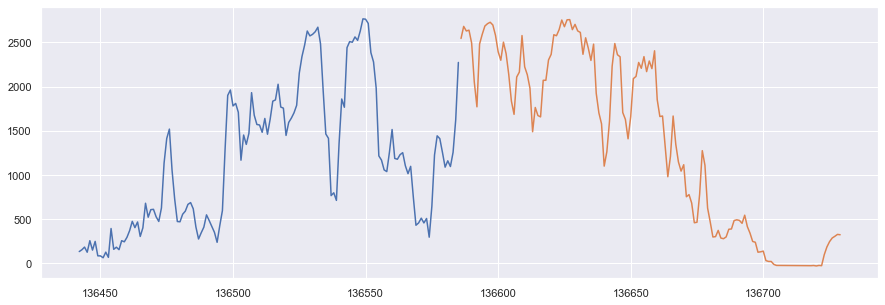

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train[-144:], train[-144:])
ax.plot(x_test[:144], test[:144])

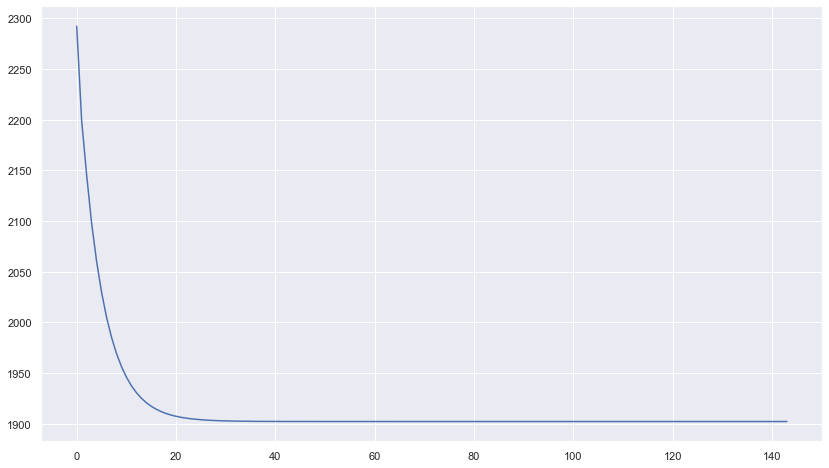

In [30]:
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)
cf= pd.DataFrame(confint)

plt.plot(prediction)

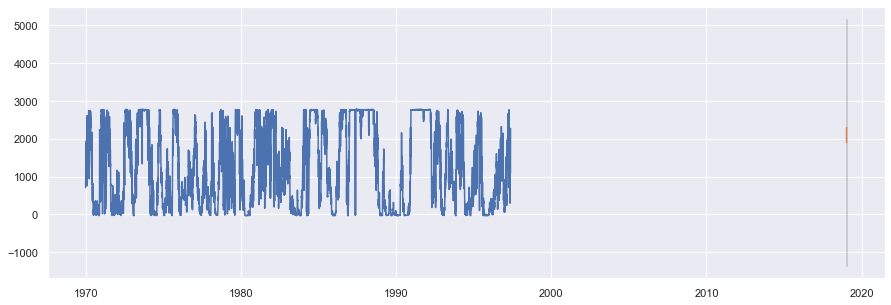

In [35]:
prediction_series = pd.Series(prediction, index=test[:144].index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.values)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution (but this is not a strict requirement to validate the model).

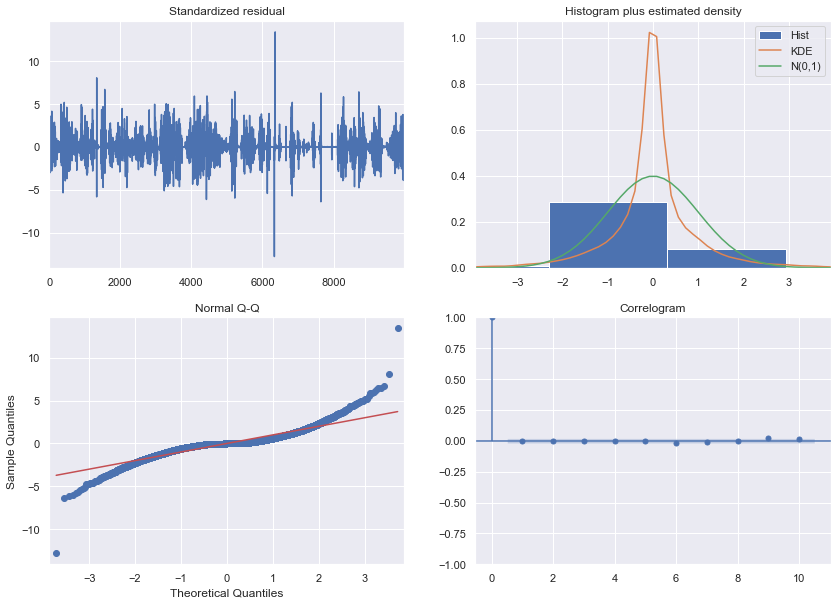

In [37]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

## Time Series Decomposition
(ARIMA does not require decomposition due to its differencing component)

_Trend_

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.[4]

_Seasonal_

A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known period. E.g. monthly sales of antidiabetic drugs show seasonality which is induced partly by the change in the cost of the drugs at the end of the calendar year.[4]

_Cyclic_

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.[4]

Wind power generation is expected to have no trend, or a weak downward trend related to wind turbine degradation. Strong seasonal or cyclic component is expected.

In [9]:
result = seasonal_decompose(power['Power(kW)'], model='additive', period=6*24)  # power_monthly

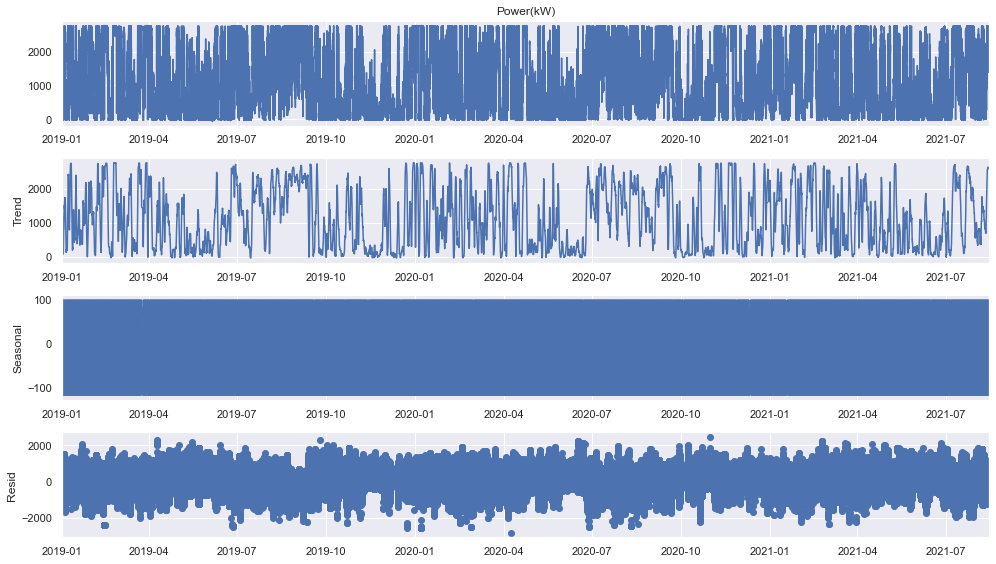

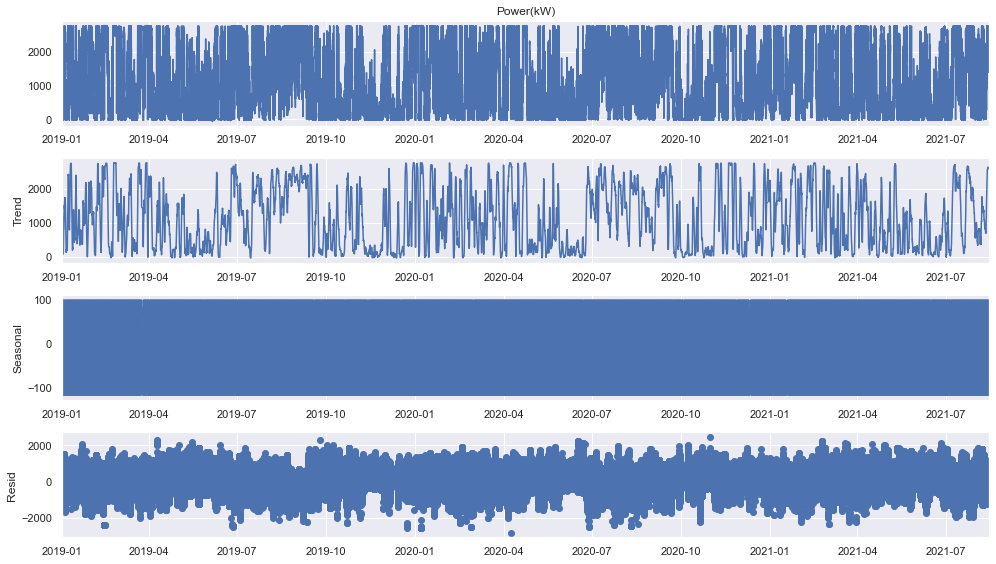

In [10]:
result.plot()

## References
[1] Methodology of developing an ARIMA model: https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

[2] Difference between autocorrelation and partial autocorrelation: https://stats.stackexchange.com/questions/483383/difference-between-autocorrelation-and-partial-autocorrelation#:~:text=Autocorrelation%20between%20X%20and%20Z,on%20X%20coming%20through%20Y.

[3] https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

[4] Book about time series forecasting: https://otexts.com/fpp3/tspatterns.html

https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/